# Classification



Using the ‘satisfied’ variable in the data, explore the use of tabular data with
different classifiers to automatically distinguish between “satisfied” and
“unsatisfied” customer responses.

Classifiers to use:

- [X] k-nearest neighbour 
- [X] decision tree
- [X] neural network
- [X] support vector machine
- [X] naive bayes


For each classifier, use 6-fold cross validation to estimate the accuracy of the classifier. \
For each classifier we will plot the confusion matrix and calculate the median of the accuracy scores.

We will also explore how to best deal in with the missing values in the data.

In [162]:

import pickle as pkl
import pandas as pd
import numpy as np
import math
import random
import time
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import sklearn.svm as svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [163]:
tabular_data = pkl.load(open('./bank-data/cleaned_customers.pkl', 'rb'))
tabular_data.drop(['customer_id', 'date', 'customer_gender', 'customer_age', 'customer_location', 'customer_type', 'has_cc', 'has_mortgage', 'customer_age_norm'], axis=1, inplace=True)

# Managing missing values

In this segment we are going to generate three different dataframes from the original one. \
These will then be used to compare the results obtained by the different classifiers.

The first dataframe will be the original one, where we will drop all the rows with missing values. \
This means we lose 1172 rows out of 30000, which constitutes a 39% of the original data. \
But it guarantees that we are not introducing any bias in the data.

The second dataframe will be the one where we impute the missing values with the mean of the column. \
This will allow us to keep all the rows, but it will introduce a bias in the data. \
More specifically it will introduce a bias towards the mean of the column so that peaks and valleys will be smoothed out.

The third dataframe will be the one where we impute the missing values with the median of the column. \
This works in the same way as the mean, but it is more robust to outliers. \
It also has the advantage of providing only integer values, which is more appropriate for the data we are dealing with.

In the forth dataframe we will try to estimate the missing values by inserting random values. \
On one hand this will allow us to keep all the rows, but shouldnt introduce any bias in the data, includin already
existing biases. \

In [164]:

# drop rows with missing values
tabular_data_no_na = tabular_data.dropna()
tabular_data_no_na.attrs['name'] = 'No missing values'

# fill missing values with mean
tabular_data_mean = tabular_data.fillna(tabular_data.mean())
tabular_data_mean.attrs['name'] = 'Mean'

# fill missing values with median
tabular_data_median = tabular_data.fillna(tabular_data.median())
tabular_data_median.attrs['name'] = 'Median'

# To have some fun and to see how a model would perform with a terrible dataset, I decided to fill the missing values with random numbers between 1 and 5.
tabular_data_random = tabular_data.fillna(math.floor(1 + (5-1)*random.random()))
tabular_data_random.attrs['name'] = 'Random'


dataframes = [tabular_data_no_na, tabular_data_mean, tabular_data_median, tabular_data_random]

## Scoring and Comparing the results

Before we can start using the different classifiers we first need to define a function that will allow us to compare the results fairly. \
Using the function below we will be able to get a score for each classifier and each dataframe. 

To get a somewhat reliable score we will use a 6-fold cross validation. \
This means that we will split the data into 6 different sets and we will use 5 of them to train the model and the remaining one to test it. \
We will then repeat this process 6 times, so that each set will be used as a test set once. \
The scores obtained in each iteration will then be averaged to get the final score.

We also make note of the median and the deviation of the scores obtained in each iteration. \
Aswell as noting the amount of false positives and false negatives obtained in each iteration and how much time it took to run the model.

In [165]:
comparison_dict = {}


def eval_and_graph (modle, modle_name,X, y, df):
    
    
    scores = cross_val_score(modle, X, y, cv=6, scoring='accuracy')

    # Calculate mean and median accuracy
    mean_accuracy = scores.mean()
    std_dev = scores.std()
    median_accuracy = np.median(scores)
    
    cv = StratifiedKFold(n_splits=6)
    summed_confusion_matrix = np.zeros((2, 2))
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        modle.fit(X_train, y_train)
        y_pred = modle.predict(X_test)
        summed_confusion_matrix += confusion_matrix(y_test, y_pred)
        
        avg_confusion_matrix = summed_confusion_matrix / 6
    
    comparison_dict[modle_name][df.attrs['name']] = {
        'mean_accuracy': mean_accuracy,
        'median_accuracy': median_accuracy,
        'std_dev': std_dev,
        'confusion_matrix': avg_confusion_matrix
    }

    print(f'{modle_name} {df.attrs["name"]} mean accuracy: {mean_accuracy}')
        

In [166]:
comparison_dict["KNN"] = {}

befin_time = time.time()
for df in dataframes:
    X = df.drop(['satisfied'], axis=1)
    y = df['satisfied']

    knn = KNeighborsClassifier(n_neighbors=5)
    
    eval_and_graph(knn,"KNN" ,X,y ,df )

comparison_dict["KNN"]["time"] = time.time() - befin_time


KNN No missing values mean accuracy: 0.8036399913718723
KNN Mean mean accuracy: 0.7860000000000001
KNN Median mean accuracy: 0.7863333333333333
KNN Random mean accuracy: 0.783


## K nearest neighbour

We will start by using the K nearest neighbour classifier. \
This classifier is based on the idea that the data points that are close to each other are more likely to belong to the same class.

Using the scikit-learn library we can easily implement this classifier. \
In this case we will use the 5 nearest neighbours and the distance metric will be the Euclidean distance.

We also use a cross validation with 6 folds to estimate the accuracy of the classifier. \
This will allow us to have a more robust estimate of the accuracy of the classifier, by splitting the data in 6 different ways and using each time a different part of the data as test set.

To evaluate the performance of the classifier we will use the confusion matrix and calculate the median of the mean, median and standard deviation of the accuracy scores. \
Based on those values we will select the best dataframe to use for the classifier.


## Decision tree

Below we will use the decision tree classifier. \
This classifier is based on the idea that the data can be split into smaller and smaller subsets, \
It works similar to a flow chart, where each node represents a test on a feature, each branch represents the outcome of the test and each leaf represents a class label. \
But unlike a flow chart, the decision tree classifier will automatically select the most discriminative features and the best split points.

To note is also that in this case the timing has been deactivated, this is because a decision tree is very nice to visualize, \
but the visualization takes a long time to render so instead of including that time in the total time we will just deactivate it.


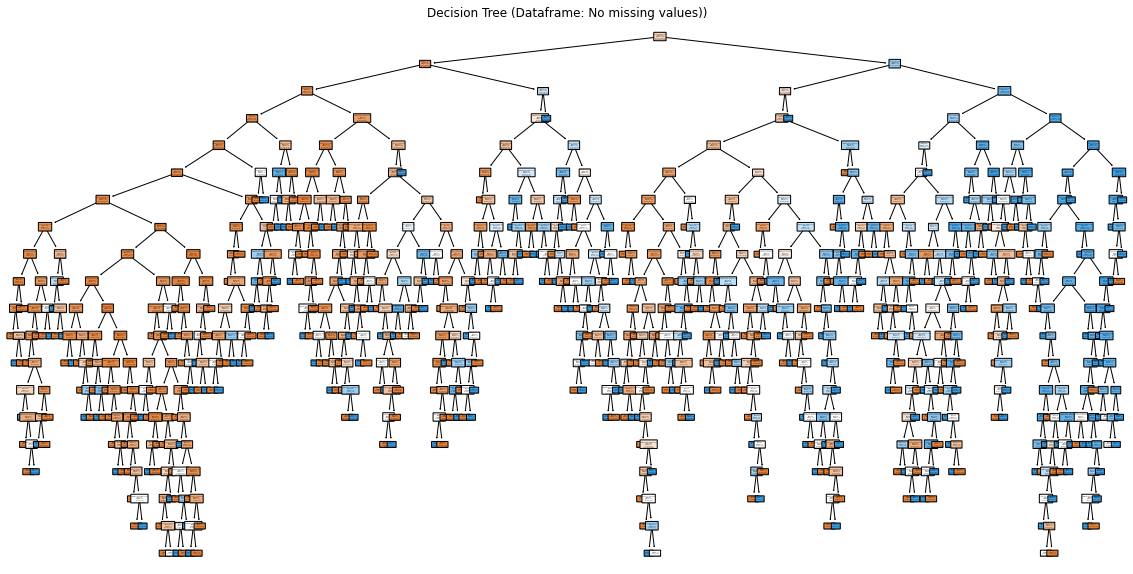

DecisionTree No missing values mean accuracy: 0.7511054788610871


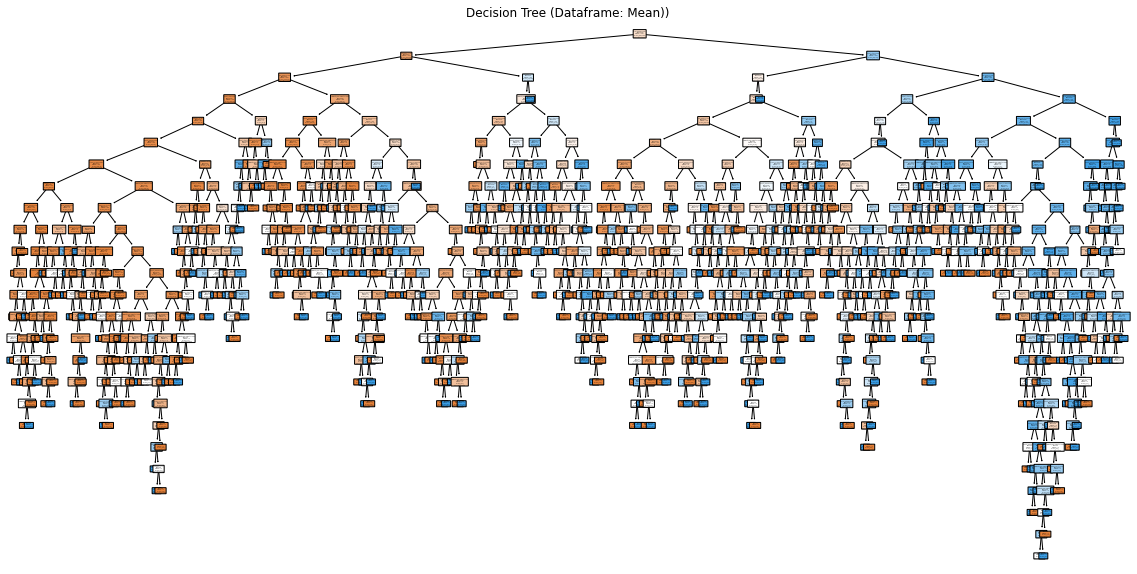

DecisionTree Mean mean accuracy: 0.7516666666666666


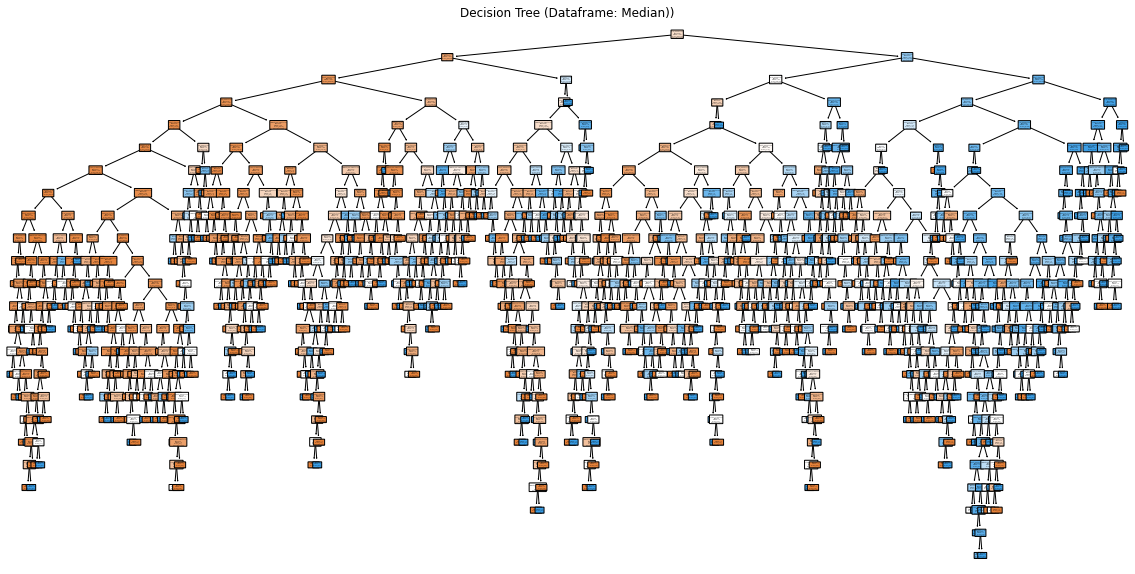

DecisionTree Median mean accuracy: 0.743


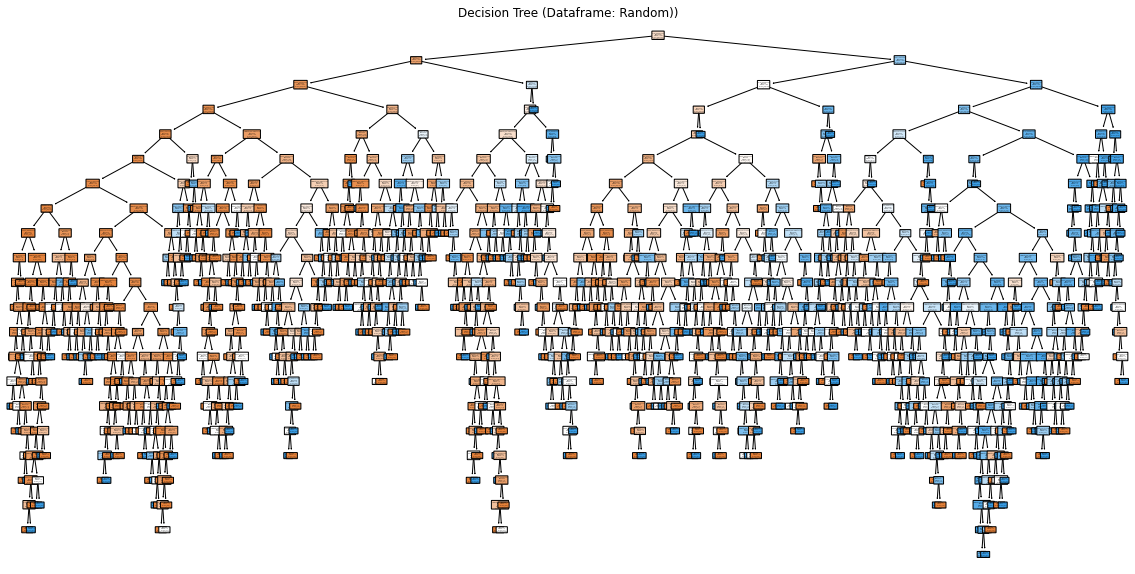

DecisionTree Random mean accuracy: 0.7463333333333333


In [173]:
import matplotlib.pyplot as plt

comparison_dict["DecisionTree"] = {}

begin = time.time()

visualise = True

for df in dataframes:
    X = df.drop(['satisfied'], axis=1)
    y = df['satisfied']

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X, y)

    # Visualize the decision tree
    if visualise:
        plt.figure(figsize=(20, 10))
        plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Not Satisfied', 'Satisfied'], rounded=True)
        plt.title(f"Decision Tree (Dataframe: {df.attrs['name']}))")
        plt.show()


    eval_and_graph(clf,"DecisionTree", X, y, df)
    
if not visualise:
    comparison_dict["DecisionTree"]["time"] = time.time() - begin
    


## Neural network

Below we will use the neural network classifier. \
This classifier is inspired by the way the human brain works. \
It is composed of layers of neurons, each neuron is connected to the neurons of the previous layer and the neurons of the next layer. \
Each connection has a weight associated with it, which is adjusted during the training phase. \
The training phase is done by feeding the network with the training data and adjusting the weights of the connections so that the output of the network is as close as possible to the expected output. \
The neural network classifier is very powerful, but it is also very computationally expensive and it requires a lot of data to train properly.

In this case we have to hidden layers, one with 64 neurons and one with 32 neurons. \
We also use the relu activation function for the hidden layers and the sigmoid activation function for the output layer. \
The relu activation function is a linear function that returns the input if it is positive and 0 otherwise. \
The sigmoid activation function is a non linear function that returns a value between 0 and 1. it looks a bit like an S. \
The sigmoid function is used for the output layer because we want to get a value between 0 and 1, which we can then use to classify the data.

During the development I adusted the number of neurons in the hidden layers and the number of hidden layers to get the best results. \
But a propper systematic approach would be a good starting point for future work.


In [168]:

comparison_dict["Neural Network"] = {}
start = time.time()

for df in dataframes:
    X = df.drop(['satisfied'], axis=1)
    y = df['satisfied']
    
    fold_accuracies = []
    confusion_matrixes = []
    kf = StratifiedKFold(n_splits=6)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create and train the model
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=80, verbose=0)

        
        # Evaluate the model
        scores = model.evaluate(X_test, y_test, verbose=0)
        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()
        
        confusion_matrixes.append(confusion_matrix(y_test, y_pred))

        fold_accuracies.append(scores[1])
        
    mean_accuracy = np.mean(fold_accuracies)
    median_accuracy = np.median(fold_accuracies)
    std_dev = np.std(fold_accuracies)
    
    comparison_dict["Neural Network"][df.attrs['name']] = {
        'mean_accuracy': mean_accuracy,
        'median_accuracy': median_accuracy,
        'std_dev': std_dev,
        'confusion_matrix': np.mean(confusion_matrixes, axis=0)
    }
    
end = time.time()
elapsed_time = end - start
comparison_dict["Neural Network"]["time"] = elapsed_time


16/16 [==============================] - 0s 1ms/step


In [169]:
# Support Vector Machine

comparison_dict["SVM"] = {}

begin = time.time()

for df in dataframes:
    X = df.drop(['satisfied'], axis=1)
    y = df['satisfied']

    clf = svm.SVC()
    clf.fit(X, y)

    eval_and_graph(clf,"SVM", X, y, df)

comparison_dict ["SVM"]["time"] = time.time() - begin

SVM No missing values mean accuracy: 0.8265908110440036
SVM Mean mean accuracy: 0.8166666666666668
SVM Median mean accuracy: 0.8163333333333332
SVM Random mean accuracy: 0.8170000000000001


## Support vector machine

A support vector machine is a classifier that tries to find the best hyperplane that separates the data into two classes. \
The hyperplane is the one that maximizes the distance between the closest points of the two classes. \
The points that are closest to the hyperplane are called support vectors. 

This is similar to the K nearest neighbour classifier, but during training only creates this hyperplane \
So when we want to predict the class of a new data point, we only need to check on which side of the hyperplane it is. 


In [170]:
# Naive Bayes

comparison_dict["NaiveBayes"] = {}

begin = time.time()
for df in dataframes:
    X = df.drop(['satisfied'], axis=1)
    y = df['satisfied']

    clf = GaussianNB()
    clf.fit(X, y)

    eval_and_graph(clf,"NaiveBayes", X, y, df)
    
comparison_dict ["NaiveBayes"]["time"] = time.time() - begin

NaiveBayes No missing values mean accuracy: 0.8003361374748347
NaiveBayes Mean mean accuracy: 0.7876666666666666
NaiveBayes Median mean accuracy: 0.789
NaiveBayes Random mean accuracy: 0.789


## Naive Bayes

Naive bayes works by calculating the statistical probability of a data point belonging to a certain class. \
By taking the product of the probabilities of each feature, we can calculate the probability of the data point belonging to a certain class. \
The class with the highest probability is the one that the data point is most likely to belong to.

Instead of mapping the datapoints in a n-dimensional space, generates propabilities for each dimension. \
This allows it to work with a smaller dataset and it is also less prone to overfitting.


In [171]:

# calculating the which dataframe has the best accuracy for each model
best_accuracy = {}

for model in comparison_dict:
    best_accuracy[model] = {}
    for df in comparison_dict[model]:
        if df != "time":
            best_accuracy[model][df] = comparison_dict[model][df]["mean_accuracy"]

# finding the best method for each model
best_methods = {}
for model in best_accuracy:
    best_method = max(best_accuracy[model], key=best_accuracy[model].get)
    best_methods[model] = {
        "method": best_method,
        "accuracy": best_accuracy[model][best_method]
    }

models = list(best_methods.keys())
methods = [best_methods[model]['method'] for model in models]
accuracies = [best_methods[model]['accuracy'] for model in models]

fig = go.Figure(go.Bar(
    x=models,
    y=accuracies,
    text=methods,
    textposition='auto',
    marker_color='indianred'
))

fig.update_layout(
    title='Best Imputation Method for Each Model',
    xaxis_title='Model',
    yaxis_title='Accuracy',
)

fig.show()


# Evaluation

Now after we have run all the classifiers and all the available dataframes we can compare the results. \
We will start of by looking at the best of the best, the classifier that performed the best on the best dataframe. \
Which is the support vector machine classifier on the dataframe without any imputation. \
This classifier had a median accuracy score of 0.826 which brings it just above the neural network classifier on the same dataframe. \
Which had a median accuracy score of 0.816.

Generaly we can see tgat the No imputation dataframe performed better than the other dataframes. \
This is a bit surprising because we would expect that having 40 percent less columns would outweight the bias introduced by the imputation. \
But it seems that the bias introduced by the imputation is more significant than the bias introduced by the missing columns.

In [178]:

colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta']

for dataset in dataframes:

    model_names = []
    confusion_matrices = []

    for model in comparison_dict:
        model_names.append(model)
        cm = comparison_dict[model][dataset.attrs["name"]]['confusion_matrix']
        cm_sum = sum(map(sum, cm))
        cm_normalized = [[value / cm_sum for value in row] for row in cm]
        confusion_matrices.append(cm_normalized)

    fig = make_subplots(rows=2, cols=2, subplot_titles=("True Positive", "True Negative", "False Positive", "False Negative"))

    for i, model_name in enumerate(model_names):
        cm = confusion_matrices[i]
        color = colors[i % len(colors)]
        fig.add_trace(go.Bar(x=[model_name], y=[cm[0][0]*100], name=model_name, showlegend=False, marker_color=color), row=1, col=1)
        fig.add_trace(go.Bar(x=[model_name], y=[cm[0][1]*100], name=model_name, showlegend=False, marker_color=color), row=2, col=2)
        fig.add_trace(go.Bar(x=[model_name], y=[cm[1][0]*100], name=model_name, showlegend=False, marker_color=color), row=2, col=1)
        fig.add_trace(go.Bar(x=[model_name], y=[cm[1][1]*100], name=model_name, showlegend=False, marker_color=color), row=1, col=2)

    fig.update_layout(title=f"Confusion Matrix Comparison (Percentage) for dataset {dataset.attrs['name']}", barmode="group")
    fig.update_xaxes(title_text="Models", row=1, col=1)
    fig.update_xaxes(title_text="Models", row=1, col=2)
    fig.update_xaxes(title_text="Models", row=2, col=1)
    fig.update_xaxes(title_text="Models", row=2, col=2)

    fig.update_yaxes(title_text="Percentage", range=[0, 60], row=1, col=1)
    fig.update_yaxes(title_text="Percentage", range=[0, 60], row=1, col=2)
    fig.update_yaxes(title_text="Percentage", range=[0, 60], row=2, col=1)
    fig.update_yaxes(title_text="Percentage", range=[0, 60], row=2, col=2)

    fig.show()


## Confusion matrixes

In the confusion matrixes above we can see the false positives and false negatives for each classifier and each method to deal with missing values. \
We can see that most of the data points are fairly similar between the different methods, but there are some differences.

Overall we can see the same pattern as before, the No imputation dataframe performs generaly better than the other dataframes. \
Being followed by the mean. 

The biggest takeaway of the differnce between the different imputation methods is that using any at all dropps the accuracy of the classifiers by roughly 3 percent. \
Even the random imputation method, which shouldnt introduce any bias, drops the general accuracy by 3 percent. \
This is a bit surprising because we would expect that having 40 percent less columns would outweight the bias introduced by the imputation.

Concerning the different classifiers we can see that the support vector machine is the best classifier overall. \
Followed by the KNN and the Neural network.

Without question the worst classifier is the decision tree. 